#### NLP

In [1]:
import nltk
import spacy
import string
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.snowball import *

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D, Bidirectional, LSTM, TimeDistributed
from keras.initializers import *
from keras.regularizers import *

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

from helpers import *
from dataset import *

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(threshold=sys.maxsize)

# Download stopwords if required
nltk.download('stopwords')
nltk.download('wordnet')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
SEED = 12345
np.random.seed(SEED)
tf.random.set_seed(SEED)

TOP_K_ONLY = False # Only Top 10 Categories considered
WORD_EMBEDDINGS = True # Use Word embeddings for Training (better results)
   

MODEL_FILE = 'pretrained/model.h5' # Path to Saved model
TRAIN_MODEL = True # train new Model or load previous saved model

EXPORT_TF = False # Export files for Java Webservice integration

# Filenames for Tensorflow Export
MODELDATA_EXPORT_FILE = 'pretrained/model_metadata.json'
PREPROCESSING_TEST_EXPORT_FILE = 'pretrained/preprocessing_test.json'
TOKENIZER_EXPORT_FILE = 'pretrained/tokenizer.json'
TF_EXPORT_DIR = 'pretrained/tensorflow'

# Others
JUG_PRESENTATION = False

# Prepare Export directory
try:
    os.makedirs(TF_EXPORT_DIR)            
except FileExistsError:
    print()

In [3]:
train_df = load_news_dataset('./data/news_train.data')#[:1000]
#train_df = load_cybertroll_dataset('./data/cybertroll_train.data')

In [4]:
CLASSNAMES = np.unique(train_df['category'])
CLASSES = len(CLASSNAMES)
train_df.head()

,id,category,headline,authors,link,short_description,date
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
print('Entries: {}'.format(len(train_df)))
print('Categories: {}'.format(CLASSES))
print(CLASSNAMES)

Entries: 200843
Categories: 41
['ARTS' 'ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COLLEGE' 'COMEDY'
 'CRIME' 'CULTURE & ARTS' 'DIVORCE' 'EDUCATION' 'ENTERTAINMENT'
 'ENVIRONMENT' 'FIFTY' 'FOOD & DRINK' 'GOOD NEWS' 'GREEN' 'HEALTHY LIVING'
 'HOME & LIVING' 'IMPACT' 'LATINO VOICES' 'MEDIA' 'MONEY' 'PARENTING'
 'PARENTS' 'POLITICS' 'QUEER VOICES' 'RELIGION' 'SCIENCE' 'SPORTS' 'STYLE'
 'STYLE & BEAUTY' 'TASTE' 'TECH' 'THE WORLDPOST' 'TRAVEL' 'WEDDINGS'
 'WEIRD NEWS' 'WELLNESS' 'WOMEN' 'WORLD NEWS' 'WORLDPOST']


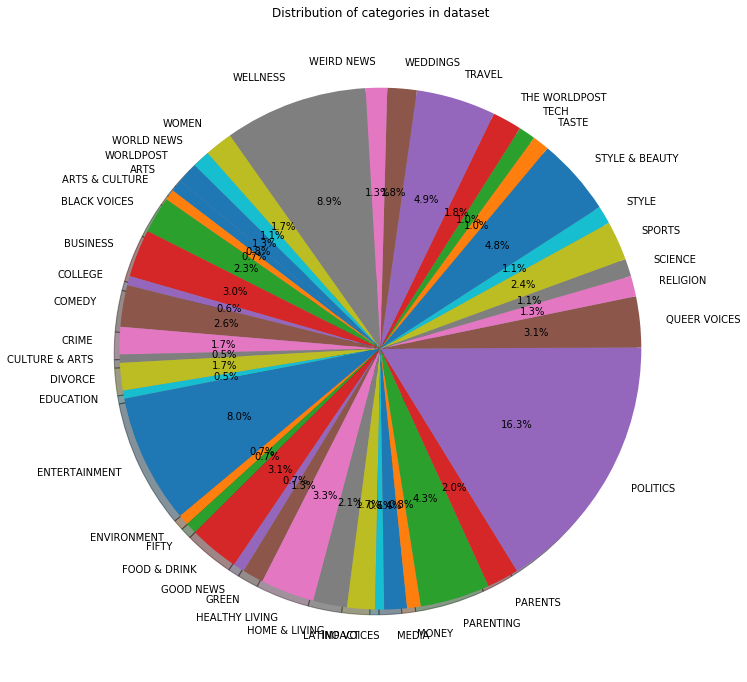

In [6]:
pie_data = []
for cn in CLASSNAMES:
    pie_data.append(train_df[train_df.category == cn].count()[0])
    
plt.figure(figsize=(15, 12))
plt.pie(pie_data, labels=CLASSNAMES, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of categories in dataset')
plt.show()

#### Top k Categories

In [7]:
top_k = 10
top_k_categories = train_df['category'].value_counts()[:top_k].index.tolist()
print('Top {} categories: {}'.format(top_k, top_k_categories))

Top 10 categories: ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS']


In [8]:
if TOP_K_ONLY:
    train_df = train_df[train_df['category'].isin(top_k_categories)]

In [9]:
CLASSNAMES = np.unique(train_df['category'])
CLASSES = len(CLASSNAMES)

print('Entries: {}'.format(len(train_df)))
print('Categories: {}'.format(CLASSES))
print(CLASSNAMES)

Entries: 200843
Categories: 41
['ARTS' 'ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COLLEGE' 'COMEDY'
 'CRIME' 'CULTURE & ARTS' 'DIVORCE' 'EDUCATION' 'ENTERTAINMENT'
 'ENVIRONMENT' 'FIFTY' 'FOOD & DRINK' 'GOOD NEWS' 'GREEN' 'HEALTHY LIVING'
 'HOME & LIVING' 'IMPACT' 'LATINO VOICES' 'MEDIA' 'MONEY' 'PARENTING'
 'PARENTS' 'POLITICS' 'QUEER VOICES' 'RELIGION' 'SCIENCE' 'SPORTS' 'STYLE'
 'STYLE & BEAUTY' 'TASTE' 'TECH' 'THE WORLDPOST' 'TRAVEL' 'WEDDINGS'
 'WEIRD NEWS' 'WELLNESS' 'WOMEN' 'WORLD NEWS' 'WORLDPOST']


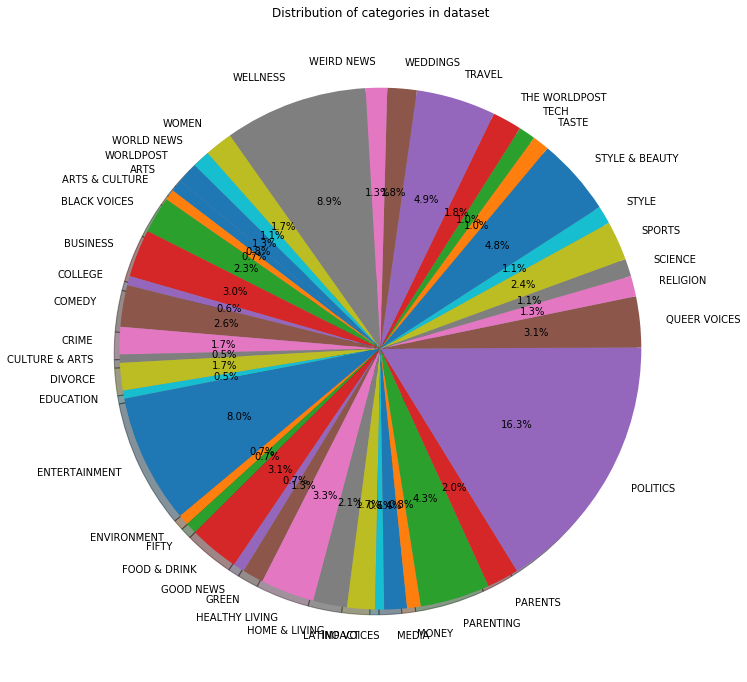

In [10]:
pie_data = []
for cn in CLASSNAMES:
    pie_data.append(train_df[train_df.category == cn].count()[0])
    
plt.figure(figsize=(15, 12))
plt.pie(pie_data, labels=CLASSNAMES, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of categories in dataset')
plt.show()

##### Fetch sentence for test

In [11]:
test_sentence = train_df['headline'].iloc[439]
test_sentence

'Stephen Colbert Wants Mueller To Give Trump A Special Anniversary Gift'

#### Count Words

In [12]:
all_words = ' '.join([text for text in train_df['headline']])
print('Number of words in all_words:', len(all_words))

Number of words in all_words: 11837756


### Wordcloud

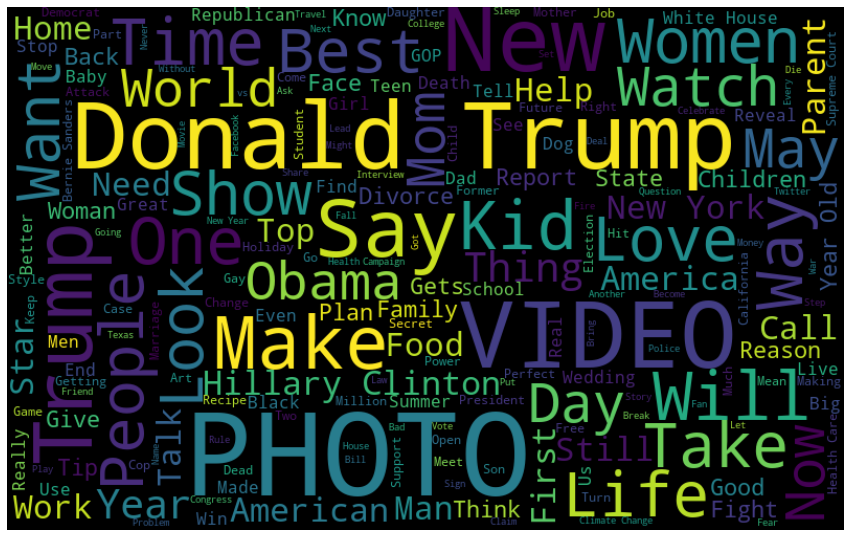

In [13]:
plot_wordcloud(train_df['headline'])

## Text Preprocessing

In [14]:
OOV_TOKEN = '<OOV>'

In [15]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
class TextPreprocessor:
    __stopwords = None
    __tokenizer = None
    __padding = None
    
    def __init__(self, tokenizer=None, padding=30):
        self.__stopwords = stopwords.words('english')
        self.__tokenizer = tokenizer
        self.__padding = padding
        
    def __remove_punctuation(self, word):
        word = ''.join([char for char in word if char not in string.punctuation])
        return word
  
    def _clean_text(self, x):
        cleaned = []
        
        stemmer = EnglishStemmer()
        
        for text in x:
            # remove special chars
            text = re.sub(u"(\u00a0)", " ", text)
            text = re.sub(u"(\u2018|\u2019)", "", text)
            
            tokens = text.split()
            
            # to lower
            tokens = [tok.lower().strip() for tok in tokens]
            
            # Stemmer
            tokens = [stemmer.stem(tok) for tok in tokens]

            # Remove punctuation
            tokens = [self.__remove_punctuation(tok) for tok in tokens]

            # Remove numbers
            tokens = ['<num>' if tok.isnumeric() else tok for tok in tokens]

            # Remove Stopwords
            tokens = [tok for tok in tokens if tok not in self.__stopwords and tok]

            tokens = ' '.join(tokens)
            cleaned.append(tokens)

        return cleaned    
   
    def _tokenize(self, x):
        if self.__tokenizer is None:            
            self.__tokenizer = Tokenizer(oov_token=OOV_TOKEN)
            self.__tokenizer.fit_on_texts(x)

        return self.__tokenizer.texts_to_sequences(x)
    
    def _pad(self, x):
        if self.__padding is None:
            self.__padding = max([len(sentence) for sentence in x])

        return pad_sequences(x, maxlen=self.__padding, padding='post', dtype='float32')
        
    def pipeline(self, x):
        preprocessed_x = self._clean_text(x)
        preprocessed_x = self._tokenize(preprocessed_x)
        preprocessed_x = self._pad(preprocessed_x)    
        return preprocessed_x

### Preprocessing Samples

In [17]:
textpreprocessor = TextPreprocessor()

#### Clean Text

In [18]:
print(test_sentence)
cleaned_sentence = textpreprocessor._clean_text([test_sentence])

print(cleaned_sentence[0])

Stephen Colbert Wants Mueller To Give Trump A Special Anniversary Gift
stephen colbert want mueller give trump special anniversari gift


#### Tokenize

In [19]:
print(cleaned_sentence)
text_tokenized = textpreprocessor._tokenize(cleaned_sentence)

print(text_tokenized)

['stephen colbert want mueller give trump special anniversari gift']
[[2, 3, 4, 5, 6, 7, 8, 9, 10]]


#### Padding

In [20]:
text_padding = textpreprocessor._pad(text_tokenized)
text_padding

array([[ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]], dtype=float32)

### Train/Test split

In [21]:
X = list(train_df['headline'])
y = list(train_df['category'])

In [22]:
label_encoder = LabelEncoder()
class_labels = label_encoder.fit(CLASSNAMES)

#### Create Vocabulary

In [23]:
vocabulary = np.unique(textpreprocessor._clean_text(train_df['headline']))
vocabulary_size = len(vocabulary)

In [24]:
MAX_FEATURES = 40000
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(vocabulary)
textpreprocessor = TextPreprocessor(tokenizer=tokenizer)
vocabulary_size = len(tokenizer.word_index)

In [ ]:
MAX_SEQUENCE_LEN = 30
X = textpreprocessor.pipeline(X)
y = to_categorical(label_encoder.transform(y))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
max_words = len(X_train[0])
num_classes = CLASSES

## Training

In [ ]:
WORD_VECTOR_DIMENSION = 200

In [ ]:
if TRAIN_MODEL and WORD_EMBEDDINGS:
    w2v_model = api.load('glove-wiki-gigaword-200')    

    embedding_matrix = np.zeros((vocabulary_size, WORD_VECTOR_DIMENSION))
    for word, i in tokenizer.word_index.items():
        if i>=max_words:
            continue
        try:
            embedding_vector = w2v_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), WORD_VECTOR_DIMENSION)

    del w2v_model    
else:
    embedding_matrix = np.zeros((vocabulary_size, WORD_VECTOR_DIMENSION))    

In [ ]:
def model_cnn_V1():
    inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='float32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=WORD_VECTOR_DIMENSION,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=MAX_SEQUENCE_LEN, trainable=True)(inputs)
    
    # Initialization and Regularisation
    xavier = glorot_normal()
    l2_reg = l2(0.004)
        
    filters = 512
    filter_sizes = [2,3,4]
    
    # http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
    strides = 2
    

    conv_0 = Conv1D(filters, kernel_size=filter_sizes[0], padding='valid', 
                    kernel_initializer=xavier, kernel_regularizer=l2_reg, activation='relu')(embedding)
    conv_1 = Conv1D(filters, kernel_size=filter_sizes[1], padding='valid', 
                    kernel_initializer=xavier, kernel_regularizer=l2_reg, activation='relu')(embedding)
    conv_2 = Conv1D(filters, kernel_size=filter_sizes[2], padding='valid', 
                    kernel_initializer=xavier, kernel_regularizer=l2_reg, activation='relu')(embedding)

    maxpool_0 = MaxPooling1D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[0] + 1), strides=strides, padding='valid')(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[1] + 1), strides=strides, padding='valid')(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[2] + 1), strides=strides, padding='valid')(conv_2)

    # Dropout Default 0.5
    
    dropout_0 = Dropout(0.25)(maxpool_0)
    dropout_1 = Dropout(0.25)(maxpool_1)
    dropout_2 = Dropout(0.25)(maxpool_2)  

    concatenated_tensor = Concatenate(axis=1)([dropout_0, dropout_1, dropout_2])           
    
    
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(0.5)(flatten)
    output = Dense(units=num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)    
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=['mse', 'accuracy'])
    
    return model



def model_cnn_V2():
    inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='float32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=WORD_VECTOR_DIMENSION,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=MAX_SEQUENCE_LEN, trainable=True)(inputs)
    
    # Initialization and Regularisation
    xavier = glorot_normal()  
    l1_reg = l1(0.004)
    l2_reg = l2(0.004)
            
    filters = 512
    filter_sizes = [2,3,4]
    
    # http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
    strides = 2
    
    conv_0 = Conv1D(filters, kernel_size=filter_sizes[0], padding='valid', 
                    kernel_initializer=xavier, 
                    kernel_regularizer=l2_reg, 
                    activity_regularizer=l1_reg,
                    activation='relu')(embedding)
    
    conv_1 = Conv1D(filters, kernel_size=filter_sizes[1], padding='valid', 
                    kernel_initializer=xavier, 
                    kernel_regularizer=l2_reg, 
                    activity_regularizer=l1_reg,
                    activation='relu')(embedding)
    
    conv_2 = Conv1D(filters, kernel_size=filter_sizes[2], padding='valid', 
                    kernel_initializer=xavier, 
                    kernel_regularizer=l2_reg, 
                    activity_regularizer=l1_reg,
                    activation='relu')(embedding)

    maxpool_0 = MaxPooling1D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[0] + 1), strides=strides, padding='valid')(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[1] + 1), strides=strides, padding='valid')(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=(MAX_SEQUENCE_LEN - filter_sizes[2] + 1), strides=strides, padding='valid')(conv_2)

    # Dropout Default 0.5
    
    dropout_0 = Dropout(0.5)(maxpool_0)
    dropout_1 = Dropout(0.5)(maxpool_1)
    dropout_2 = Dropout(0.5)(maxpool_2)  

    concatenated_tensor = Concatenate(axis=1)([dropout_0, dropout_1, dropout_2])               
    
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(0.5)(flatten)
    output = Dense(units=num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)    
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=['mse', 'accuracy'])
    
    return model

def model_rnn_V1():   
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size, output_dim=WORD_VECTOR_DIMENSION,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=MAX_SEQUENCE_LEN, trainable=True))
    model.add(SpatialDropout1D(0.5))
    model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse', 'accuracy'])  
    
    return model

def model_rnn_V2():
    xavier = glorot_normal()  
    l1_reg = l1()
    l2_reg = l2()    
    
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size, output_dim=WORD_VECTOR_DIMENSION,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=MAX_SEQUENCE_LEN))
    model.add(SpatialDropout1D(0.5))
   
    model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, 
                    kernel_initializer=xavier, 
                    kernel_regularizer=l2_reg, 
                    activity_regularizer=l1_reg))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse', 'accuracy'])  
    
    return model


#model = model_reference()
#model = model()
model = model_rnn_V2()
model.summary()

In [ ]:
BATCH_SIZE = 16
EPOCHS = 30
#EPOCHS = 15

#### Balance Dataset

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df['category']),
                                                 train_df['category'])
class_weights

In [ ]:
def train():
    checkpoint = ModelCheckpoint(MODEL_FILE, verbose=1, save_best_only=True, save_weights_only=False)
    earlystopping = EarlyStopping(patience=5, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, min_delta=0.000001)
    
    logdir = './logs/' + time.strftime("%Y%m%d_%H%M%S")
    os.mkdir(logdir)
    tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_images=True, profile_batch = 100000000,
                             embeddings_freq=1)
                             #embeddings_data=X_train) 

    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2, 
                        callbacks=[checkpoint, earlystopping, tensorboard, reduce_lr],
                        class_weight=class_weights)
    
    score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    print(score)
    
    plot_history(history)
    
if TRAIN_MODEL:
    train()
else:
    model = load_model(MODEL_FILE)

## Show Results

#### Load Pretrained Model and Tokenizer for Presentation

In [ ]:
if JUG_PRESENTATION:
    with open('final/tokenizer.json') as tokenizer_file:
        data = tokenizer_file.read()
        tokenizer = tokenizer_from_json(data)
        tokenizer_file.close()

    model = load_model('final/model.h5')

#### Confusion Matrix

In [ ]:
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, CLASSNAMES)

#### Single Prediction Test

In [ ]:
#test_sentence = 'Will Ferrell And Molly Shannon Cover The Royal Wedding As \'Cord And Tish\'' # ENTERTAINMENT # FAIL
#test_sentence = 'White House Officials Reportedly Considered Just \'Ignoring\' New Climate Research' # POLITICS # CORRECT
#test_sentence = 'Beyond the Pill: Physicians\' Trend for 2013' #WELLNESS # CORRECT
#test_sentence = 'U.S. Launches Auto Import Probe, China Vows To Defend Its Interests' # BUSINESS # FAIL
#test_sentence = 'We Tasted The New Fruit Punch Oreos, So You Don\'t Have To' # FOOD & DRINK # CORRECT
test_sentence = 'Wake-Up Calls Inspired My Change From Overdrive and Sleep Deprived' # HEALTHY_LIVING # FAIL
#test_sentence = '10 Ways to De-Stress Dinnertime With Young Kids' # PARENTING # CORRECT
#test_sentence = 'Queer New World: Meet Brooklyn\'s Trey LaTrash' # QUEER VOICES # CORRECT
#test_sentence = '7 Fashion Mistakes You\'ll Regret Forever' # STYLE & BEAUTY # CORRECT
#test_sentence = 'Best Travel Apps And Hacks For Your Vacation Workout' # TRAVEL # CORRECT

preprocessed_test_sentence = textpreprocessor.pipeline([test_sentence])

print('Text: {}\n'.format(test_sentence))

prediction = model.predict(preprocessed_test_sentence)[0]
print('Prediciton Array: {} {}'.format(prediction, np.sum(prediction)))
print('Prediction Value: {}'.format(np.argmax(prediction)))

prediction_argmax = np.argmax(prediction)
print("Prediction Text: {}".format(CLASSNAMES[prediction_argmax]))
prediction = (prediction*100).astype(int)

print(CLASSNAMES)

In [ ]:
plot_prediction_bar(prediction, CLASSNAMES)

#### Helper functions

In [ ]:
def text_preprocessing_steps(sentence):
    clean = textpreprocessor._clean_text([sentence])
    tokenized = textpreprocessor._tokenize(clean)
    padded = textpreprocessor._pad(tokenized)
    
    preprocessed = textpreprocessor.pipeline([sentence])
    prediction = model.predict(preprocessed)
    
    return clean, tokenized[0], padded[0], preprocessed[0], prediction

In [ ]:
test_sentence = 'Will Ferrell And Molly Shannon Cover The Royal Wedding As \'Cord And Tish\'' # ENTERTAINMENT # FAIL
test_sentence = '7 Fashion Mistakes You\'ll Regret Forever' # STYLE & BEAUTY # CORRECT
test_sentence = 'Best Travel Apps And Hacks For Your Vacation Workout' # TRAVEL # CORRECT

print(test_sentence)
clean, tokenized, padded, preprocessed, predicted = text_preprocessing_steps(test_sentence)
print('cleaned: {}'.format(clean))
print('tokenized: {}'.format(tokenized))
print('padded: {}'.format(padded))
print('preprocessed: {}'.format(preprocessed))
print('predicted: {}'.format(predicted))

### Tensorflow Export
Exports the tokenizer, the categories and a data for the black box test as well as the tensorflow model for integration into the Java web service: https://github.com/tobiassteidle/NLP-Text-Classification-Webservice

In [ ]:
if EXPORT_TF:    
    def text_preprocessing_steps(sentence):
        clean = textpreprocessor._clean_text([sentence])
        tokenized = textpreprocessor._tokenize(clean)
        padded = textpreprocessor._pad(tokenized)
        preprocessed = textpreprocessor.pipeline([sentence])
        prediction = model.predict(preprocessed)[0]

        return clean, tokenized[0], padded[0], preprocessed[0], prediction    
    
    test_sentences = train_df['headline'][:1000]
    
    # Export Tokenizer
    file_tokenizer = open(TOKENIZER_EXPORT_FILE, 'w')
    file_tokenizer.write(tokenizer.to_json()) 
    file_tokenizer.close() 
    
    # Model Data (Categories)
    modeldata = { 'classes': CLASSNAMES.tolist() }    
    file_modeldata = open(MODELDATA_EXPORT_FILE, 'w')
    file_modeldata.write(json.dumps(modeldata, sort_keys=True, indent=4))
    file_modeldata.close()        
    
    # Data for Blackbox Test
    test_data = []
    for test_sentence in test_sentences:
        text = re.sub(u"(\u00a0)", " ", test_sentence)
        text = re.sub(u"(\u2018|\u2019)", "", text)
        
        clean, tokenized, padded, preprocessed, prediction = text_preprocessing_steps(test_sentence)        
        test_data.append({
            'sentence': text,
            'cleaned': clean,
            'tokenized': tokenized,
            'padded': padded.tolist(),
            'preprocessed': preprocessed.tolist(),
            'predicted': prediction.tolist()
        })    
    
    preprocessing_data = { 'test_sentences': test_data }    
    file_preprocessing_data = open(PREPROCESSING_TEST_EXPORT_FILE, 'w')
    file_preprocessing_data.write(json.dumps(preprocessing_data, sort_keys=True, indent=4))
    file_preprocessing_data.close()      
    
    # Export Tensorflow Model
    model.save(TF_EXPORT_DIR, save_format='tf')
    
    print('Export complete.')